In [3]:
rm(list=ls())
model_root <-'/snfs2/HOME/pyliu/git/ubcov_central/modules/model'
setwd(model_root)
source('init.r')
source('register_data.r')

os <- .Platform$OS.type
if (os == "windows") {
  j <- "J:/"
  h <- "H:/"
} else {
  j <- "/home/j/"
  user <- Sys.info()[["user"]]
  h <- paste0("/snfs2/HOME/", user)
}
library(ggplot2)


source(paste0(j, "/WORK/01_covariates/02_inputs/hsa/code/init.r"))
draws_root <- paste0(j, "/temp/pyliu/scratch/draws/exp")
library(survey, lib.loc="/share/local/R-3.1.2/lib64/R/library")

[1] "Paths loaded"


In [46]:
## Create survey design object
setup.design <- function(df, var) {
	## Conservative adjustment recommended by Thomas Lumley for single-PSU strata.  Centers the data for the single-PSU stratum around the sample grand mean rather than the stratum mean
	options(survey.lonely.psu = 'adjust')
	## conservative adjustment recommended by Thomas Lumley for single-PSU within subpopulations.  Need to find out more about what exactly this is doing.
	options(survey.adjust.domain.lonely = TRUE)
	## Check for survey design vars
	check_list <- c("strata", "psu", "pweight")
	for (i in check_list) {
  		## Assign to *_formula the variable if it exists and nonmissing, else NULL
  		assign(paste0(i, "_formula"),
    	ifelse(i %in% names(df) & nrow(df[!is.na(i)]) > 0, paste("~", i), NULL) %>% as.formula
  		) 
	}
	## Set svydesign
	return(svydesign(id = psu_formula, weight = pweight_formula, strat = strata_formula, data = df[!is.na(var)], nest = TRUE))
}

##-------------------------------------------------------------------------

## Core function to collapse dataframe
collapse.by <- function(df, var, by_vars, calc.sd = FALSE) {
  ## Subset dataframe to where not missing variable or survey design variables
  df.c <- df[!is.na(get(var)) & !is.na(strata) & !is.na(psu) & !is.na(pweight)] %>% copy
  ## Setup design
  design <- setup.design(df, var)
  ## Setup by the by call as a formula
  by_formula <- as.formula(paste0("~", paste(by_vars, collapse = "+")))
  ## Calculate number of observations, number of clusters, strata
  meta <- df[, list(sample_size = length(which(!is.na(get(var)))), 
                      nclust = length(unique(psu)), 
                      nstrata= length(unique(strata)),
                      var = var
                      ), by = by_vars]
  ## Calculate mean and standard error by by_var(s).  Design effect is dependent on the scaling of the sampling weights
  est <- svyby(~get(var), by_formula, svymean, design = design, deff = "replace", na.rm = TRUE, drop.empty.groups = TRUE, keep.names = FALSE, multicore=TRUE) %>% data.table
  old <- c("get(var)", "DEff.get(var)", "se")
  new <- c("mean", "design_effect", "standard_error")
  setnames(est, old, new)
  ## Merge
  out <- merge(meta, est, by=by_vars)

  ## Calculate standard deviation by by_vars(s), Design effect is dependent on the scaling of the sampling weights
  if (calc.sd) {
    stdev <- svyby(~get(var), by_formula, svyvar, design = design, deff = "replace", na.rm = TRUE, drop.empty.groups = TRUE, keep.names = FALSE, multicore=TRUE) %>% data.table
    setnames(stdev, "get(var)", "variance")
    stdev <- stdev[, standard_deviation := sqrt(variance)]
    #Calculating standard error of stdev (not variance) as per http://stats.stackexchange.com/questions/156518/what-is-the-standard-error-of-the-sample-standard-deviation
    stdev <- stdev[, standard_deviation_se := 1 / (2*standard_deviation) * se]
    stdev <- stdev[, c("se", "variance") := NULL]
    ## Merge
    out <- merge(out, stdev, by=by_vars)
  }
  return(out)                     
}

In [80]:
## Load example DHS
files <- list.files(paste0(extract_root, "/vaccination"), full.names=TRUE)

In [89]:
card.summary <- function(df) {
if ("dpt3_age_month" %in% names(df)) {
## Clear out all age at vaccination < 0, which arise from issues in birth date or recorded card dates
cols <- grep("_age_month", names(df), value=TRUE)
df <- df[, (cols) := lapply(.SD, function(x) ifelse(x < 0, NA, x)), .SDcols=cols]
## On time
df <- df[!is.na(dpt3_age_month), dpt3_on_time := ifelse(dpt3_age_month < 12, 1, 0)]
## Reshape dose var
df <- df[!is.na(dpt_dose), dpt3 := ifelse(dpt_dose >= 3, 1, 0)]
df <- df[!is.na(dpt_dose), dpt3_card := ifelse(dpt_dose >= 3 & !is.na(dpt3_age_month), 1, 0)]
## Summarize 
cols <- c("dpt3", "dpt3_card", "dpt3_age_month", "dpt3_on_time")
df.s <- lapply(cols, function(x) collapse.by(df, x, "age_year")) %>% rbindlist
df.s <- dcast(df.s, age_year ~ var, value.var = "mean")
## Clean 
meta <- df[1, 1:7]
df.out <- cbind(meta, df.s)
return(df.out)
} else {
    return(NULL)
}
}

In [115]:
df <- mclapply(files, function(x) {
    tryCatch({
        card.summary(fread(x))
    }, error= function(x) return(NULL))  
}, mc.cores=10) %>% rbindlist(., use.names=TRUE, fill=TRUE)

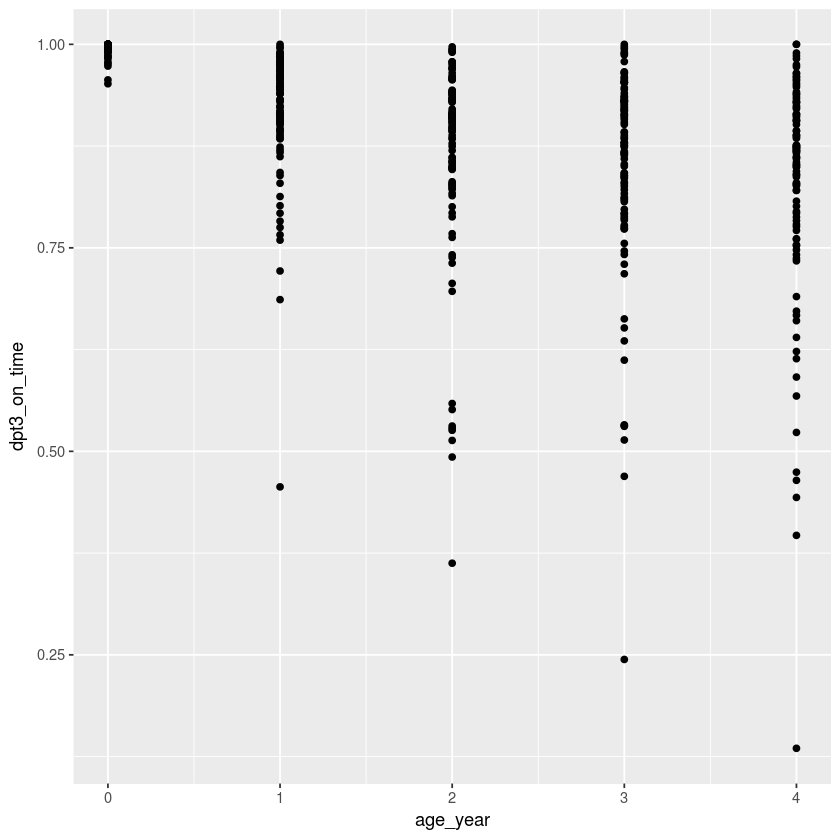

In [129]:
ggplot(df) +
    geom_point(aes(y=dpt3_on_time, x=age_year))

In [127]:
head(df)

nid   survey_name ihme_loc_id year_start year_end survey_module
1 56830 UNICEF_MICS AFG         2010       2011     CH           
2 56830 UNICEF_MICS AFG         2010       2011     CH           
3 56830 UNICEF_MICS AFG         2010       2011     CH           
4 56830 UNICEF_MICS AFG         2010       2011     CH           
5 56830 UNICEF_MICS AFG         2010       2011     CH           
6   687 UNICEF_MICS AGO         2001       2001     CH           
  file_path                                                               
1 J:/DATA/UNICEF_MICS/AFG/2010_2011/AFG_MICS4_2010_2011_CH_Y2013M09D09.DTA
2 J:/DATA/UNICEF_MICS/AFG/2010_2011/AFG_MICS4_2010_2011_CH_Y2013M09D09.DTA
3 J:/DATA/UNICEF_MICS/AFG/2010_2011/AFG_MICS4_2010_2011_CH_Y2013M09D09.DTA
4 J:/DATA/UNICEF_MICS/AFG/2010_2011/AFG_MICS4_2010_2011_CH_Y2013M09D09.DTA
5 J:/DATA/UNICEF_MICS/AFG/2010_2011/AFG_MICS4_2010_2011_CH_Y2013M09D09.DTA
6 J:/DATA/UNICEF_MICS/AGO/2001/AGO_MICS2_2001_CH_Y2008M09D23.DTA          
  age_year dpt3      dpt3_age_month dpt3_card  dpt3_on_time
1 0        0.5140269  4.754218      0.17547833 1.0000000   
2 1        0.4909877  7.250638      0.25634115 0.8426000   
3 2        0.4725829  8.878853      0.17762656 0.7382128   
4 3        0.4194657 11.212249      0.12421667 0.6516004   
5 4        0.3741505 11.309738      0.08112607 0.6226845   
6 0        0.2196216  4.401103      0.17997769 0.9913502